# Mental Health ML Pipeline
Complete machine learning pipeline for psychiatric disorder prediction and risk assessment

In [16]:
# Cell 1: Library Imports
import pandas as pd
import numpy as np
import warnings
import os
import joblib
import pickle
import logging
from datetime import datetime

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Advanced ML Models
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# NLP Libraries
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

# Hyperparameter optimization
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not available, using GridSearchCV for hyperparameter tuning")

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Download NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    pass

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn imported successfully")

All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 1.26.4
Scikit-learn imported successfully


Loading data from: attached_assets\Cleaned mental health data.csv

=== DATASET OVERVIEW ===
Dataset shape: (764, 111)

Columns (111):
 1. Unnamed: 0
 2. Diagnosis
 3. LowerBP
 4. RespiratoryRate
 5. Temp
 6. Weight
 7. Height
 8. UpperBP
 9. Informant
10. Relation
11. PresentComplaint
12. IllnessHistory
13. OnsetAge
14. Episode
15. Duration
16. Cause
17. IsSubstanceReported
18. IsAlcohol
19. IsMarijuana
20. IsOpium
21. IsHeroin
22. SubstanceOther
23. UseDuration
24. InitialDose
25. PresentDose
26. DoseFrequency
27. TakingWay
28. Drugs
29. TreatmentResponse
30. PsychiatricOther
31. PreviousIllness
32. PreviousRemarks
33. PresentIllness
34. DrugAlergy
35. IsHygieneAppropriate
36. IsPostureAppropriate
37. IsBehaviourCooperative
38. IsMotorPsycho
39. ISGroomingAppropriate
40. ISSpeechPressure
41. ISSpeechNormal
42. ISSpeechRapid
43. ISSpeechSlow
44. ISSpeechWhispered
45. ISSpeechLoud
46. ISSpeechSpontaneous
47. ISSpeechMute
48. ISSpeechShuttering
49. ISSpeechContentRelevant
50. HygieneOthe

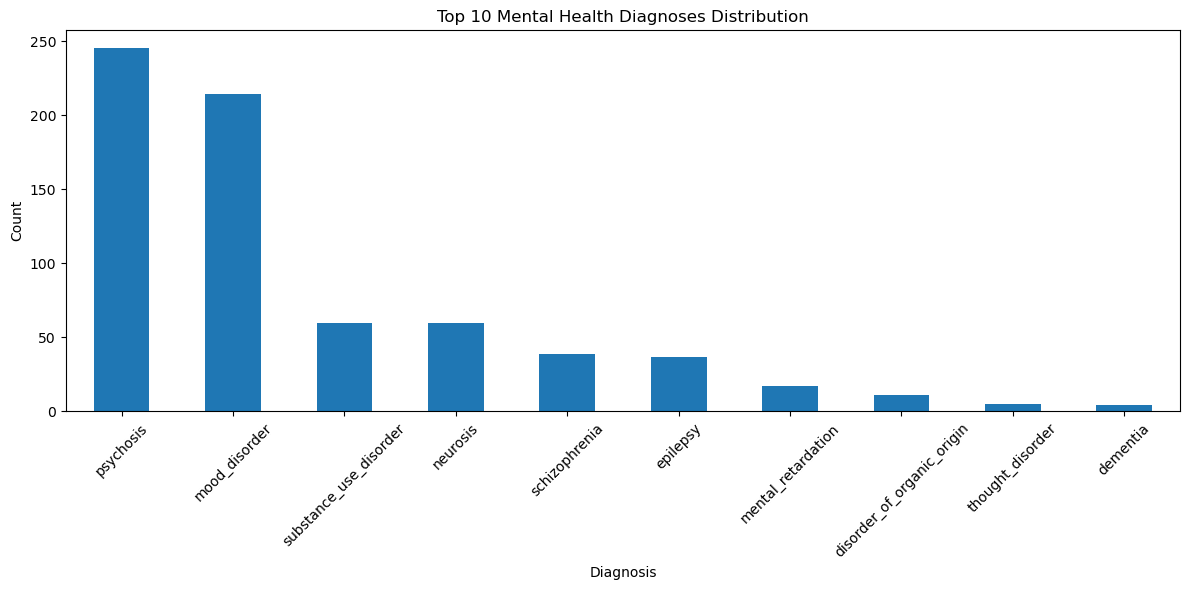


=== SAMPLE DATA ===
   Unnamed: 0        Diagnosis   LowerBP  RespiratoryRate      Temp    Weight  \
0           0        psychosis -1.013358        -0.233028 -0.101399 -0.879101   
1           1       high_sleep  0.006541        -0.233028 -0.101399  0.943114   
2           2  child_psychosis  3.168228         0.457560  8.221720  2.412643   
3           3    mood_disorder  0.006541        -0.193566 -0.101399  0.237741   
4           4         epilepsy -1.013358        -0.233028 -0.101399  0.414084   

     Height   UpperBP  Informant  Relation  ... AttentionOther  \
0  0.319342 -0.835042          1         1  ...            N/R   
1  0.398879  0.107449          1         1  ...            NaN   
2 -4.055152 -0.740793          1         1  ...            N/R   
3  0.160270  0.107449          0         0  ...            N/R   
4  0.398879  1.049940          1         1  ...            NaN   

  LongMemoryOther  AbstractOther  JudgementOther  Recomendations NextVisitDte  \
0             

In [17]:
# Cell 2: Data Loading and Exploration

def load_mental_health_data():
    """Load mental health dataset from various possible sources"""
    path = "attached_assets\Cleaned mental health data.csv"
    
    if os.path.exists(path):
        print(f"Loading data from: {path}")
        return pd.read_csv(path)
    
    # If no file found, create a sample structure for demonstration
    print("No dataset found. Please ensure Mental_Health_Dataset.csv is available.")
    print("Expected columns: Diagnosis, PresentComplaint, OnsetAge, Duration, Episode, etc.")
    return None

# Load the dataset
df = load_mental_health_data()

if df is not None:
    print("\n=== DATASET OVERVIEW ===")
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns ({len(df.columns)}):")
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")
    
    print("\n=== DATA TYPES ===")
    print(df.dtypes)
    
    print("\n=== MISSING VALUES ===")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))
    
    if 'Diagnosis' in df.columns:
        print("\n=== TARGET VARIABLE DISTRIBUTION ===")
        target_dist = df['Diagnosis'].value_counts()
        print(target_dist)
        
        print(f"\nNumber of unique diagnoses: {df['Diagnosis'].nunique()}")
        print(f"Most common diagnosis: {target_dist.index[0]} ({target_dist.iloc[0]} cases)")
        print(f"Least common diagnosis: {target_dist.index[-1]} ({target_dist.iloc[-1]} cases)")
        
        # Visualize target distribution
        plt.figure(figsize=(12, 6))
        target_dist.head(10).plot(kind='bar')
        plt.title('Top 10 Mental Health Diagnoses Distribution')
        plt.xlabel('Diagnosis')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    print("\n=== SAMPLE DATA ===")
    print(df.head())
    
else:
    print("Please add the Mental Health Dataset to continue with the pipeline.")

In [18]:
# Cell 3: Data Cleaning and Preprocessing

def clean_and_preprocess_data(df):
    """Comprehensive data cleaning and preprocessing"""
    if df is None:
        return None
    
    print("Starting data cleaning and preprocessing...")
    
    # Create a copy
    processed_df = df.copy()
    
    # Clean column names
    processed_df.columns = processed_df.columns.str.strip().str.replace(' ', '_')
    print(f"Cleaned column names: {list(processed_df.columns)}")
    
    # --- Explicitly drop unwanted columns ---
    drop_cols = ['NextVisitDte', 'Unnamed:_0', 'Unnamed_0']
    existing_drop_cols = [col for col in drop_cols if col in processed_df.columns]
    if existing_drop_cols:
        print(f"Dropping unwanted columns: {existing_drop_cols}")
        processed_df = processed_df.drop(columns=existing_drop_cols)

    # --- Handle target ---
    if 'Diagnosis' not in processed_df.columns:
        print("❌ Error: 'Diagnosis' column not found!")
        return None

    diagnosis_counts = processed_df['Diagnosis'].value_counts()
    valid_classes = diagnosis_counts[diagnosis_counts >= 20].index
    processed_df = processed_df[processed_df['Diagnosis'].isin(valid_classes)]
    print(f"✅ Remaining classes after filtering: {len(valid_classes)}")

    processed_df['Diagnosis'] = processed_df['Diagnosis'].astype(str).fillna('unknown')

    # Drop columns with >80% missing
    missing_threshold = 0.8
    missing_percent = processed_df.isnull().sum() / len(processed_df)
    cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()
    if cols_to_drop:
        print(f"Dropping {len(cols_to_drop)} columns with >80% missing values")
        processed_df = processed_df.drop(columns=cols_to_drop)
    
    # --- Numeric conversion ---
    numeric_columns = [
        'OnsetAge', 'Duration', 'Episode', 'LowerBP', 'UpperBP',
        'RespiratoryRate', 'Temp', 'Weight', 'Height', 'DoseFrequency'
    ]
    for col in numeric_columns:
        if col in processed_df.columns:
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    
    # --- Binary column conversion ---
    binary_columns = [
        'IsSubstanceReported', 'IsAlcohol', 'IsMarijuana', 'IsOpium',
        'IsHeroin', 'IsHygieneAppropriate', 'IsPostureAppropriate', 'IsBehaviourCooperative'
    ]
    for col in binary_columns:
        if col in processed_df.columns:
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').fillna(0).astype(int)

    # --- Derived Features ---
    if 'Weight' in processed_df.columns and 'Height' in processed_df.columns:
        valid_height = (processed_df['Height'] > 0) & (processed_df['Height'].notna())
        processed_df['BMI'] = np.where(valid_height,
            processed_df['Weight'] / (processed_df['Height'] ** 2),
            0
        )
        print("✅ Created BMI feature")

    if 'LowerBP' in processed_df.columns and 'UpperBP' in processed_df.columns:
        processed_df['BP_Diff'] = processed_df['UpperBP'] - processed_df['LowerBP']
        processed_df['Mean_BP'] = (processed_df['UpperBP'] + processed_df['LowerBP']) / 2
        print("✅ Created BP difference and mean")

    if 'OnsetAge' in processed_df.columns:
        processed_df['OnsetAge_Group'] = pd.cut(
            processed_df['OnsetAge'].fillna(0),
            bins=[0, 18, 30, 50, 100],
            labels=['Child', 'Young_Adult', 'Adult', 'Senior']
        ).astype(str)

    print(f"✅ Final processed dataset shape: {processed_df.shape}")
    return processed_df

# Clean and preprocess the data
if df is not None:
    cleaned_df = clean_and_preprocess_data(df)
    if cleaned_df is not None:
        print("\n=== DATA CLEANING SUMMARY ===")
        print(f"Original shape: {df.shape}")
        print(f"Cleaned shape: {cleaned_df.shape}")
        print(f"Unique diagnoses after cleaning: {cleaned_df['Diagnosis'].nunique()}")
        
        # Show sample of cleaned data
        print("\n=== CLEANED DATA SAMPLE ===")
        print(cleaned_df.head())
else:
    cleaned_df = None

Starting data cleaning and preprocessing...
Cleaned column names: ['Unnamed:_0', 'Diagnosis', 'LowerBP', 'RespiratoryRate', 'Temp', 'Weight', 'Height', 'UpperBP', 'Informant', 'Relation', 'PresentComplaint', 'IllnessHistory', 'OnsetAge', 'Episode', 'Duration', 'Cause', 'IsSubstanceReported', 'IsAlcohol', 'IsMarijuana', 'IsOpium', 'IsHeroin', 'SubstanceOther', 'UseDuration', 'InitialDose', 'PresentDose', 'DoseFrequency', 'TakingWay', 'Drugs', 'TreatmentResponse', 'PsychiatricOther', 'PreviousIllness', 'PreviousRemarks', 'PresentIllness', 'DrugAlergy', 'IsHygieneAppropriate', 'IsPostureAppropriate', 'IsBehaviourCooperative', 'IsMotorPsycho', 'ISGroomingAppropriate', 'ISSpeechPressure', 'ISSpeechNormal', 'ISSpeechRapid', 'ISSpeechSlow', 'ISSpeechWhispered', 'ISSpeechLoud', 'ISSpeechSpontaneous', 'ISSpeechMute', 'ISSpeechShuttering', 'ISSpeechContentRelevant', 'HygieneOther', 'PostureOther', 'MotorOther', 'GroomingOther', 'SpeechOther', 'ModeSubjective', 'ISObjectiveEuthymia', 'ISObjective

In [19]:
# Cell 4: Advanced Feature Engineering

def extract_nlp_features(text_series, feature_prefix='text'):
    """Extract NLP features from text data"""
    features_list = []
    
    # Psychiatric keywords for different conditions
    psychiatric_keywords = {
        'depression': ['sad', 'depressed', 'hopeless', 'worthless', 'empty', 'tearful'],
        'anxiety': ['anxious', 'worried', 'nervous', 'panic', 'fear', 'scared'],
        'psychosis': ['voices', 'hallucinations', 'paranoid', 'suspicious', 'delusions'],
        'mania': ['elevated', 'high energy', 'hyperactive', 'grandiose', 'euphoric'],
        'substance': ['alcohol', 'drugs', 'marijuana', 'addiction', 'withdrawal']
    }
    
    for text in text_series.fillna(''):
        text = str(text).lower()
        
        # Basic text features
        features = {
            f'{feature_prefix}_length': len(text),
            f'{feature_prefix}_word_count': len(text.split()),
            f'{feature_prefix}_sentence_count': len(text.split('.')) if text else 0,
        }
        
        # Sentiment analysis using TextBlob
        try:
            blob = TextBlob(text)
            features[f'{feature_prefix}_sentiment_polarity'] = blob.sentiment.polarity
            features[f'{feature_prefix}_sentiment_subjectivity'] = blob.sentiment.subjectivity
        except:
            features[f'{feature_prefix}_sentiment_polarity'] = 0
            features[f'{feature_prefix}_sentiment_subjectivity'] = 0
        
        # Keyword counts for different psychiatric conditions
        for condition, keywords in psychiatric_keywords.items():
            count = sum(1 for keyword in keywords if keyword in text)
            features[f'{feature_prefix}_{condition}_keywords'] = count
        
        # Urgency indicators
        urgent_words = ['emergency', 'crisis', 'suicide', 'kill', 'death', 'urgent', 'help']
        features[f'{feature_prefix}_urgency_score'] = sum(1 for word in urgent_words if word in text)
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)

def create_interaction_features(df, numeric_cols):
    """Create interaction features between important variables"""
    interaction_df = pd.DataFrame(index=df.index)
    
    # Age-related interactions
    if 'OnsetAge' in numeric_cols and 'Duration' in numeric_cols:
        interaction_df['Age_Duration_Ratio'] = df['OnsetAge'] / (df['Duration'] + 1)
        interaction_df['Age_Duration_Product'] = df['OnsetAge'] * df['Duration']
    
    # Substance abuse combinations
    substance_cols = ['IsAlcohol', 'IsMarijuana', 'IsOpium', 'IsHeroin']
    available_substance_cols = [col for col in substance_cols if col in df.columns]
    if available_substance_cols:
        interaction_df['Total_Substances'] = df[available_substance_cols].sum(axis=1)
        interaction_df['Poly_Substance_Use'] = (df[available_substance_cols].sum(axis=1) > 1).astype(int)
    
    # Behavioral combinations
    behavior_cols = ['IsHygieneAppropriate', 'IsPostureAppropriate', 'IsBehaviourCooperative']
    available_behavior_cols = [col for col in behavior_cols if col in df.columns]
    if available_behavior_cols:
        interaction_df['Behavioral_Score'] = df[available_behavior_cols].sum(axis=1)
    
    return interaction_df

def advanced_feature_engineering(df):
    """Apply advanced feature engineering techniques"""
    if df is None:
        return None
    
    print("Starting advanced feature engineering...")
    
    # Separate features and target
    target = df['Diagnosis'].copy()
    feature_df = df.drop('Diagnosis', axis=1)
    
    # Extract numerical features
    numeric_cols = feature_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = feature_df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")
    
    # Initialize final feature matrix
    final_features = pd.DataFrame(index=df.index)
    
    # Add numeric features with imputation
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='median')
        numeric_features = pd.DataFrame(
            numeric_imputer.fit_transform(feature_df[numeric_cols]),
            columns=numeric_cols,
            index=feature_df.index
        )
        final_features = pd.concat([final_features, numeric_features], axis=1)
    
    # Process text features
    text_cols = ['PresentComplaint', 'IllnessHistory']
    for col in text_cols:
        if col in feature_df.columns:
            print(f"Extracting NLP features from {col}...")
            nlp_features = extract_nlp_features(feature_df[col], col.lower())
            final_features = pd.concat([final_features, nlp_features], axis=1)
    
    # Create interaction features
    if numeric_cols:
        print("Creating interaction features...")
        interaction_features = create_interaction_features(feature_df, numeric_cols)
        final_features = pd.concat([final_features, interaction_features], axis=1)
    
    # Handle categorical variables with one-hot encoding
    categorical_features = pd.DataFrame(index=df.index)
    for col in categorical_cols:
        if col in feature_df.columns and feature_df[col].nunique() > 1:
            # Limit categories to avoid high cardinality
            top_categories = feature_df[col].value_counts().head(10).index
            feature_df[col] = feature_df[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )
            dummies = pd.get_dummies(feature_df[col], prefix=col, dummy_na=True)
            categorical_features = pd.concat([categorical_features, dummies], axis=1)
    
    if not categorical_features.empty:
        final_features = pd.concat([final_features, categorical_features], axis=1)
    
    # Fill any remaining missing values
    final_features = final_features.fillna(0)
    
    print(f"Final feature matrix shape: {final_features.shape}")
    print(f"Number of features created: {len(final_features.columns)}")
    
    return final_features, target

# Apply advanced feature engineering
if cleaned_df is not None:
    X_engineered, y_target = advanced_feature_engineering(cleaned_df)
    
    if X_engineered is not None:
        print("\n=== FEATURE ENGINEERING SUMMARY ===")
        print(f"Features created: {X_engineered.shape[1]}")
        print(f"Samples: {X_engineered.shape[0]}")
        print(f"Target classes: {y_target.nunique()}")
        
        # Show feature categories
        feature_categories = {
            'NLP': [col for col in X_engineered.columns if any(text in col for text in ['presentcomplaint', 'illnesshistory'])],
            'Interaction': [col for col in X_engineered.columns if any(term in col for term in ['ratio', 'product', 'total', 'score'])],
            'Demographic': [col for col in X_engineered.columns if any(term in col for term in ['age', 'onset'])],
            'Clinical': [col for col in X_engineered.columns if any(term in col for term in ['bp', 'temp', 'weight', 'height'])]
        }
        
        for category, features in feature_categories.items():
            if features:
                print(f"{category} features: {len(features)}")
else:
    X_engineered, y_target = None, None

Starting advanced feature engineering...
Numeric columns: 78
Categorical columns: 29
Extracting NLP features from PresentComplaint...
Extracting NLP features from IllnessHistory...
Creating interaction features...
Final feature matrix shape: (759, 444)
Number of features created: 444

=== FEATURE ENGINEERING SUMMARY ===
Features created: 444
Samples: 759
Target classes: 6
NLP features: 22
Interaction features: 6


Starting feature selection from 78 features...
✅ After variance threshold: 70 features retained
⚠️ Dropping 1 highly correlated features
✅ After correlation filter: 69 features retained
✅ Mutual Information selected: 69 features
✅ Final selected features: 69


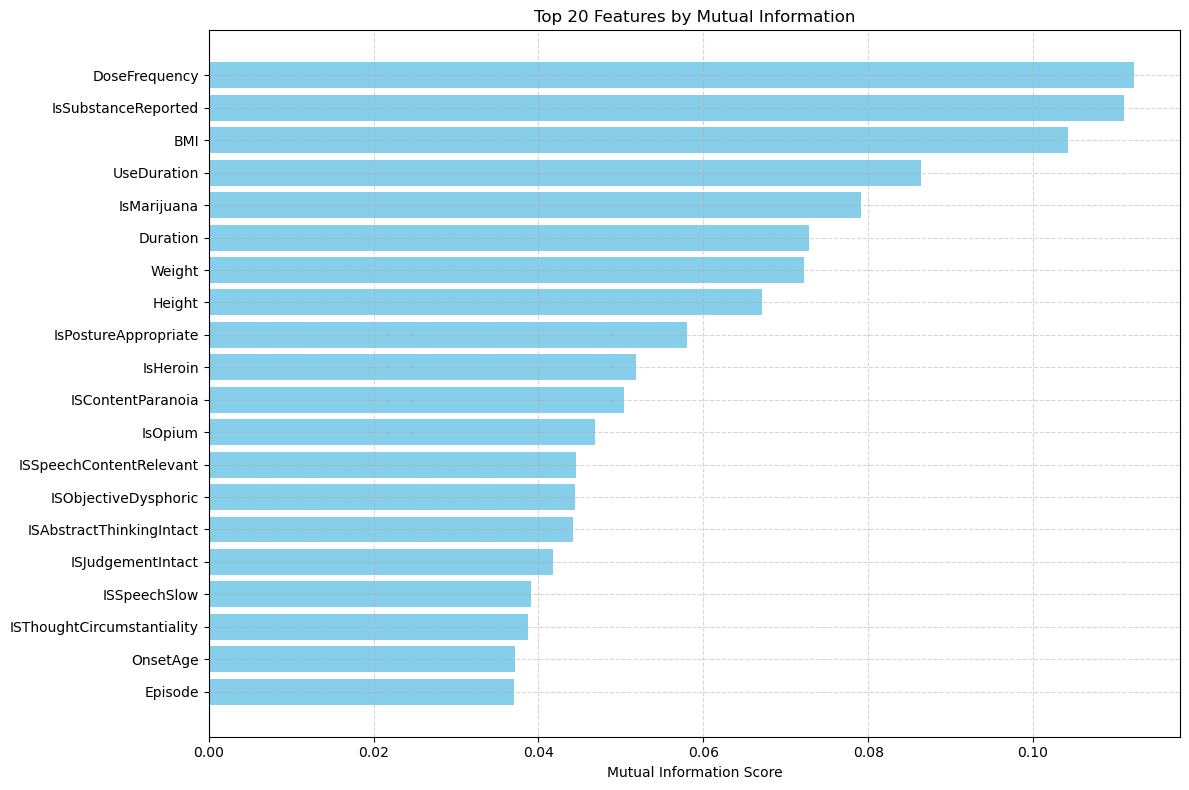


✅ Feature Selection Complete
Selected 69 features
                feature  mutual_info_score
16        DoseFrequency           0.112223
10  IsSubstanceReported           0.111000
66                  BMI           0.104281
15          UseDuration           0.086441
12          IsMarijuana           0.079185


In [20]:
# Cell 5: Feature Selection Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, VarianceThreshold
from sklearn.preprocessing import LabelEncoder

def perform_feature_selection(X, y, n_features=50):
    """Comprehensive feature selection pipeline"""
    print(f"Starting feature selection from {X.shape[1]} features...")

    # --- Sanitize features ---
    X = X.copy()
    X = X.replace([np.inf, -np.inf], np.nan)

    # Drop columns with any NaNs (or use fillna(0) if preferred)
    nan_cols = X.columns[X.isna().any()]
    if len(nan_cols):
        print(f"⚠️ Dropping {len(nan_cols)} columns with NaNs: {list(nan_cols)}")
    X = X.dropna(axis=1)

    # --- Remove low variance features ---
    variance_selector = VarianceThreshold(threshold=0.01)
    X_variance = variance_selector.fit_transform(X)
    selected_variance_features = X.columns[variance_selector.get_support()]
    print(f"✅ After variance threshold: {X_variance.shape[1]} features retained")

    X_variance_df = pd.DataFrame(X_variance, columns=selected_variance_features, index=X.index)

    # --- Remove highly correlated features ---
    corr_matrix = X_variance_df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]

    if high_corr_features:
        print(f"⚠️ Dropping {len(high_corr_features)} highly correlated features")

    X_corr_filtered = X_variance_df.drop(columns=high_corr_features)
    print(f"✅ After correlation filter: {X_corr_filtered.shape[1]} features retained")

    # --- Encode target ---
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # --- Mutual Information Selection ---
    k_mi = min(n_features, X_corr_filtered.shape[1])
    mi_selector = SelectKBest(score_func=mutual_info_classif, k=k_mi)
    X_mi = mi_selector.fit_transform(X_corr_filtered, y_encoded)
    selected_mi_features = X_corr_filtered.columns[mi_selector.get_support()]
    mi_scores = mi_selector.scores_[mi_selector.get_support()]
    print(f"✅ Mutual Information selected: {len(selected_mi_features)} features")

    # --- F-score Selection ---
    f_selector = SelectKBest(score_func=f_classif, k=k_mi)
    f_selector.fit(X_corr_filtered, y_encoded)
    selected_f_features = X_corr_filtered.columns[f_selector.get_support()]

    # --- Combine MI and F-score selections ---
    combined_features = list(set(selected_mi_features) | set(selected_f_features))
    X_final = X_corr_filtered[combined_features]
    print(f"✅ Final selected features: {len(combined_features)}")

    # --- Feature Importance DataFrame ---
    feature_importance_df = pd.DataFrame({
        'feature': selected_mi_features,
        'mutual_info_score': mi_scores
    }).sort_values(by='mutual_info_score', ascending=False)

    # --- Visualization ---
    if not feature_importance_df.empty:
        plt.figure(figsize=(12, 8))
        top_n = min(20, len(feature_importance_df))
        top_features = feature_importance_df.head(top_n)
        plt.barh(top_features['feature'], top_features['mutual_info_score'], color='skyblue')
        plt.xlabel('Mutual Information Score')
        plt.title(f'Top {top_n} Features by Mutual Information')
        plt.gca().invert_yaxis()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return X_final, feature_importance_df, combined_features

# Run this after your data cleaning and preprocessing
if cleaned_df is not None:
    y = cleaned_df['Diagnosis']
    X = cleaned_df.drop(columns=['Diagnosis'])

    # Only keep numeric columns (drop text, categorical)
    X = X.select_dtypes(include=[np.number])

    # Now safe to proceed
    X_selected, importance_df, selected_features = perform_feature_selection(X, y, n_features=100)

    print("\n✅ Feature Selection Complete")
    print(f"Selected {len(selected_features)} features")
    print(importance_df.head())
else:
    print("No cleaned data available for feature selection. Please ensure the data is preprocessed first.")

Splitting and balancing data...
Target classes: 6
Class distribution before balancing:
  epilepsy: 37 (5.6%)
  mood_disorder: 214 (32.7%)
  neurosis: 60 (9.2%)
  psychosis: 245 (37.4%)
  schizophrenia: 39 (6.0%)
  substance_use_disorder: 60 (9.2%)
Train set: 524 samples
Test set: 131 samples
Applied smote balancing
Balanced train set: 1176 samples
Class distribution after balancing:
  epilepsy: 196 (16.7%)
  mood_disorder: 196 (16.7%)
  neurosis: 196 (16.7%)
  psychosis: 196 (16.7%)
  schizophrenia: 196 (16.7%)
  substance_use_disorder: 196 (16.7%)
Applied feature scaling

=== DATA SPLITTING SUMMARY ===
Training samples: 1176
Test samples: 131
Features: 69
Classes: 6


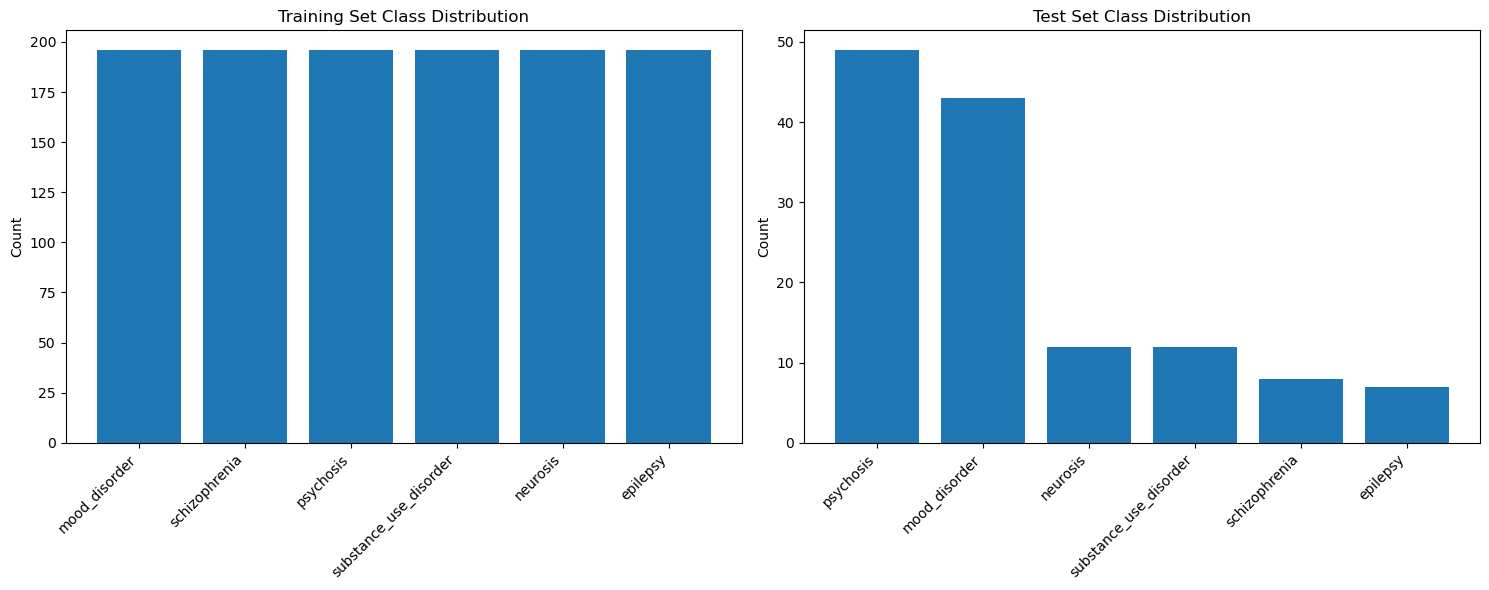

In [21]:
# Cell 6: Data Splitting and Balancing

def split_and_balance_data(X, y, test_size=0.2, balance_method='smote'):
    """Split data and apply balancing techniques"""
    print("Splitting and balancing data...")
    
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"Target classes: {len(label_encoder.classes_)}")
    print(f"Class distribution before balancing:")
    unique, counts = np.unique(y_encoded, return_counts=True)
    for i, (cls, count) in enumerate(zip(label_encoder.classes_[unique], counts)):
        print(f"  {cls}: {count} ({count/len(y)*100:.1f}%)")
    
    # Check if stratification is possible
    min_class_count = min(counts)
    if min_class_count < 2:
        print("Warning: Some classes have < 2 samples. Using random split.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=42
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Apply balancing to training data
    X_train_balanced, y_train_balanced = X_train, y_train
    
    if balance_method and len(np.unique(y_train)) > 1:
        min_samples = min(np.unique(y_train, return_counts=True)[1])
        
        if min_samples >= 2:  # Need at least 2 samples per class for SMOTE
            try:
                if balance_method == 'smote':
                    k_neighbors = min(5, min_samples - 1)
                    balancer = SMOTE(random_state=42, k_neighbors=k_neighbors)
                elif balance_method == 'adasyn':
                    k_neighbors = min(5, min_samples - 1)
                    balancer = ADASYN(random_state=42, n_neighbors=k_neighbors)
                elif balance_method == 'smote_tomek':
                    k_neighbors = min(5, min_samples - 1)
                    balancer = SMOTETomek(random_state=42, smote=SMOTE(k_neighbors=k_neighbors))
                else:
                    print(f"Unknown balance method: {balance_method}")
                    balancer = None
                
                if balancer:
                    X_train_balanced, y_train_balanced = balancer.fit_resample(X_train, y_train)
                    print(f"Applied {balance_method} balancing")
                    print(f"Balanced train set: {X_train_balanced.shape[0]} samples")
                    
                    # Show new distribution
                    unique_bal, counts_bal = np.unique(y_train_balanced, return_counts=True)
                    print("Class distribution after balancing:")
                    for cls, count in zip(label_encoder.classes_[unique_bal], counts_bal):
                        print(f"  {cls}: {count} ({count/len(y_train_balanced)*100:.1f}%)")
                        
            except Exception as e:
                print(f"Balancing failed: {e}. Using original training data.")
        else:
            print("Skipping balancing due to insufficient samples per class.")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    print("Applied feature scaling")
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train_balanced,
        'y_test': y_test,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'feature_names': X.columns.tolist()
    }

# Split and balance the data
if X_selected is not None and y_target is not None:
    data_splits = split_and_balance_data(X_selected, y_target, balance_method='smote')
    
    print("\n=== DATA SPLITTING SUMMARY ===")
    print(f"Training samples: {data_splits['X_train'].shape[0]}")
    print(f"Test samples: {data_splits['X_test'].shape[0]}")
    print(f"Features: {data_splits['X_train'].shape[1]}")
    print(f"Classes: {len(data_splits['label_encoder'].classes_)}")
    
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set distribution
    train_labels = data_splits['label_encoder'].inverse_transform(data_splits['y_train'])
    train_counts = pd.Series(train_labels).value_counts()
    ax1.bar(range(len(train_counts)), train_counts.values)
    ax1.set_xticks(range(len(train_counts)))
    ax1.set_xticklabels(train_counts.index, rotation=45, ha='right')
    ax1.set_title('Training Set Class Distribution')
    ax1.set_ylabel('Count')
    
    # Test set distribution
    test_labels = data_splits['label_encoder'].inverse_transform(data_splits['y_test'])
    test_counts = pd.Series(test_labels).value_counts()
    ax2.bar(range(len(test_counts)), test_counts.values)
    ax2.set_xticks(range(len(test_counts)))
    ax2.set_xticklabels(test_counts.index, rotation=45, ha='right')
    ax2.set_title('Test Set Class Distribution')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
else:
    data_splits = None

In [22]:
# Cell 7: Model Training (Multiple Algorithms)

def train_multiple_models(X_train, y_train, X_test, y_test):
    """Train multiple ML models with optimized parameters"""
    print("Training multiple models...")
    
    models = {}
    model_scores = {}
    
    # Model configurations
    model_configs = {
        'Random Forest': {
            'model': RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            ),
            'description': 'Ensemble of decision trees'
        },
        'CatBoost': {
            'model': CatBoostClassifier(
                iterations=500,
                learning_rate=0.1,
                depth=6,
                random_seed=42,
                verbose=False,
                allow_writing_files=False
            ),
            'description': 'Gradient boosting on decision trees'
        },
        'XGBoost': {
            'model': xgb.XGBClassifier(
                n_estimators=300,
                learning_rate=0.1,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                eval_metric='mlogloss'
            ),
            'description': 'Extreme gradient boosting'
        },
        'LightGBM': {
            'model': lgb.LGBMClassifier(
                n_estimators=300,
                learning_rate=0.1,
                max_depth=6,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbose=-1
            ),
            'description': 'Light gradient boosting machine'
        }
    }
    
    # Train each model
    for name, config in model_configs.items():
        print(f"\nTraining {name}...")
        model = config['model']
        
        try:
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            # ROC AUC (handle multiclass)
            try:
                if len(np.unique(y_test)) > 2:
                    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
                else:
                    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            except:
                roc_auc = None
            
            # Cross-validation score
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
            
            # Store results
            models[name] = model
            model_scores[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'description': config['description']
            }
            
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print(f"  ROC-AUC: {roc_auc:.4f}" if roc_auc else "  ROC-AUC: N/A")
            print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            
        except Exception as e:
            print(f"  Error training {name}: {str(e)}")
            continue
    
    return models, model_scores

# Train models
if data_splits is not None:
    trained_models, model_performance = train_multiple_models(
        data_splits['X_train'],
        data_splits['y_train'],
        data_splits['X_test'],
        data_splits['y_test']
    )
    
    print("\n=== MODEL TRAINING SUMMARY ===")
    print(f"Successfully trained {len(trained_models)} models")
    
    # Create performance comparison dataframe
    performance_df = pd.DataFrame(model_performance).T
    performance_df = performance_df.sort_values('f1_score', ascending=False)
    
    print("\n=== MODEL PERFORMANCE COMPARISON ===")
    print(performance_df[['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean']].round(4))
    
else:
    trained_models, model_performance = None, None

Training multiple models...

Training Random Forest...
  Accuracy: 0.4733
  Precision: 0.4671
  Recall: 0.4733
  F1-Score: 0.4638
  ROC-AUC: 0.7417
  CV Score: 0.7714 (+/- 0.1338)

Training CatBoost...
  Accuracy: 0.5344
  Precision: 0.5243
  Recall: 0.5344
  F1-Score: 0.5208
  ROC-AUC: 0.7742
  CV Score: 0.7867 (+/- 0.1750)

Training XGBoost...
  Accuracy: 0.5267
  Precision: 0.5298
  Recall: 0.5267
  F1-Score: 0.5203
  ROC-AUC: 0.7750
  CV Score: 0.7706 (+/- 0.2256)

Training LightGBM...
  Accuracy: 0.5267
  Precision: 0.5229
  Recall: 0.5267
  F1-Score: 0.5166
  ROC-AUC: 0.7604
  CV Score: 0.7680 (+/- 0.2307)

=== MODEL TRAINING SUMMARY ===
Successfully trained 4 models

=== MODEL PERFORMANCE COMPARISON ===
               accuracy precision    recall  f1_score   cv_mean
CatBoost       0.534351  0.524278  0.534351  0.520791  0.786708
XGBoost        0.526718  0.529848  0.526718   0.52028  0.770591
LightGBM       0.526718   0.52287  0.526718   0.51661  0.768049
Random Forest  0.473282 

In [28]:
# Cell 8: Hyperparameter Optimization

def optimize_hyperparameters(X_train, y_train, model_type='random_forest', n_trials=10):
    """Optimize hyperparameters using Optuna"""
    print(f"Optimizing hyperparameters for: {model_type}")

    def objective(trial):
        if model_type == 'random_forest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 6, 12),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
                'random_state': 42,
                'n_jobs': -1
            }
            model = RandomForestClassifier(**params)

        elif model_type == 'catboost':
            params = {
                'iterations': trial.suggest_int('iterations', 300, 700),
                'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
                'depth': trial.suggest_int('depth', 4, 8),
                'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5),
                'random_seed': 42,
                'verbose': False,
                'allow_writing_files': False
            }
            model = CatBoostClassifier(**params)

        elif model_type == 'xgboost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 200, 400),
                'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
                'max_depth': trial.suggest_int('max_depth', 4, 8),
                'subsample': trial.suggest_float('subsample', 0.8, 1.0),
                'random_state': 42,
                'eval_metric': 'mlogloss',
                'n_jobs': -1,
                'use_label_encoder': False
            }
            model = xgb.XGBClassifier(**params)

        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        return cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted').mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params
    best_score = study.best_value

    print(f"✅ Best score for {model_type}: {best_score:.4f}")
    print(f"✅ Best params: {best_params}")

    # Instantiate final model
    if model_type == 'random_forest':
        best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    elif model_type == 'catboost':
        best_model = CatBoostClassifier(**best_params, random_seed=42, verbose=False, allow_writing_files=False)
    elif model_type == 'xgboost':
        best_model = xgb.XGBClassifier(**best_params, random_state=42, eval_metric='mlogloss', use_label_encoder=False)

    best_model.fit(X_train, y_train)
    return best_model, best_params, best_score

def optimize_top_models(X_train, y_train, model_performance, top_n=2):
    performance_df = pd.DataFrame(model_performance).T
    top_models = performance_df.sort_values('f1_score', ascending=False).head(top_n)

    optimized_models = {}

    for model_name in top_models.index:
        print(f"\n=== Optimizing {model_name} ===")
        model_key_map = {
            'Random Forest': 'random_forest',
            'CatBoost': 'catboost',
            'XGBoost': 'xgboost'
        }

        if model_name in model_key_map:
            model_key = model_key_map[model_name]
            result = optimize_hyperparameters(X_train, y_train, model_key)
            if result:
                optimized_model, best_params, best_score = result
                optimized_models[model_name] = {
                    'model': optimized_model,
                    'best_params': best_params,
                    'best_score': best_score
                }
        else:
            print(f"❌ Optimization not implemented for {model_name}")

    return optimized_models

# Call and display results from the optimization
if data_splits is not None and model_performance is not None:
    optimized_models = optimize_top_models(
        data_splits['X_train'],
        data_splits['y_train'],
        model_performance,
        top_n=2
    )

    print("\n=== HYPERPARAMETER OPTIMIZATION SUMMARY ===")
    for model_name, info in optimized_models.items():
        print(f"\n📌 {model_name}")
        print(f"  ✅ Optimized F1 Score: {info['best_score']:.4f}")
        print(f"  ⚙️ Best Parameters: {info['best_params']}")
        
        # Optional: compare to original
        original_f1 = model_performance[model_name]['f1_score']
        delta = info['best_score'] - original_f1
        print(f"  📉 Original F1: {original_f1:.4f}")
        print(f"  📈 Improvement: {delta:+.4f}")
else:
    print("❌ Skipping optimization: missing data_splits or model_performance")

[I 2025-07-01 18:12:29,841] A new study created in memory with name: no-name-4406b33c-3152-43b8-b269-e5b447948ae2



=== Optimizing CatBoost ===
Optimizing hyperparameters for: catboost


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-01 18:12:50,900] Trial 0 finished with value: 0.7700353612939771 and parameters: {'iterations': 607, 'learning_rate': 0.13432807770141741, 'depth': 5, 'l2_leaf_reg': 4}. Best is trial 0 with value: 0.7700353612939771.
[I 2025-07-01 18:14:42,622] Trial 1 finished with value: 0.7890493400638016 and parameters: {'iterations': 419, 'learning_rate': 0.10965249881134054, 'depth': 8, 'l2_leaf_reg': 5}. Best is trial 1 with value: 0.7890493400638016.
[I 2025-07-01 18:14:57,223] Trial 2 finished with value: 0.7709101481447527 and parameters: {'iterations': 417, 'learning_rate': 0.08588793409506282, 'depth': 5, 'l2_leaf_reg': 1}. Best is trial 1 with value: 0.7890493400638016.
[I 2025-07-01 18:15:07,865] Trial 3 finished with value: 0.7603033428265528 and parameters: {'iterations': 306, 'learning_rate': 0.07809601928520085, 'depth': 5, 'l2_leaf_reg': 2}. Best is trial 1 with value: 0.7890493400638016.
[I 2025-07-01 18:16:37,123] Trial 4 finished with value: 0.7817633299422696 and para

[I 2025-07-01 18:22:23,440] A new study created in memory with name: no-name-c7f23746-ab24-403b-a4e4-895afbdd0166



=== Optimizing XGBoost ===
Optimizing hyperparameters for: xgboost


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-01 18:22:31,799] Trial 0 finished with value: 0.7741676447323153 and parameters: {'n_estimators': 373, 'learning_rate': 0.08318701197933775, 'max_depth': 6, 'subsample': 0.81002407155782}. Best is trial 0 with value: 0.7741676447323153.
[I 2025-07-01 18:22:37,914] Trial 1 finished with value: 0.7751049180906971 and parameters: {'n_estimators': 227, 'learning_rate': 0.10514081575757164, 'max_depth': 7, 'subsample': 0.9760908529413015}. Best is trial 1 with value: 0.7751049180906971.
[I 2025-07-01 18:22:42,490] Trial 2 finished with value: 0.7745103035934866 and parameters: {'n_estimators': 234, 'learning_rate': 0.06541800016168171, 'max_depth': 4, 'subsample': 0.935379256994195}. Best is trial 1 with value: 0.7751049180906971.
[I 2025-07-01 18:22:48,350] Trial 3 finished with value: 0.7801619182931909 and parameters: {'n_estimators': 302, 'learning_rate': 0.05674943007010874, 'max_depth': 4, 'subsample': 0.9247919637159434}. Best is trial 3 with value: 0.7801619182931909.
[I 

Performing comprehensive model evaluation...

Evaluating CatBoost (Optimized)...
Classification Report for CatBoost (Optimized):
                        precision    recall  f1-score   support

              epilepsy       0.12      0.14      0.13         7
         mood_disorder       0.57      0.58      0.57        43
              neurosis       0.00      0.00      0.00        12
             psychosis       0.57      0.73      0.64        49
         schizophrenia       0.50      0.12      0.20         8
substance_use_disorder       0.80      0.67      0.73        12

              accuracy                           0.54       131
             macro avg       0.43      0.38      0.38       131
          weighted avg       0.51      0.54      0.52       131


Evaluating XGBoost (Optimized)...
Classification Report for XGBoost (Optimized):
                        precision    recall  f1-score   support

              epilepsy       0.00      0.00      0.00         7
         mood_dis

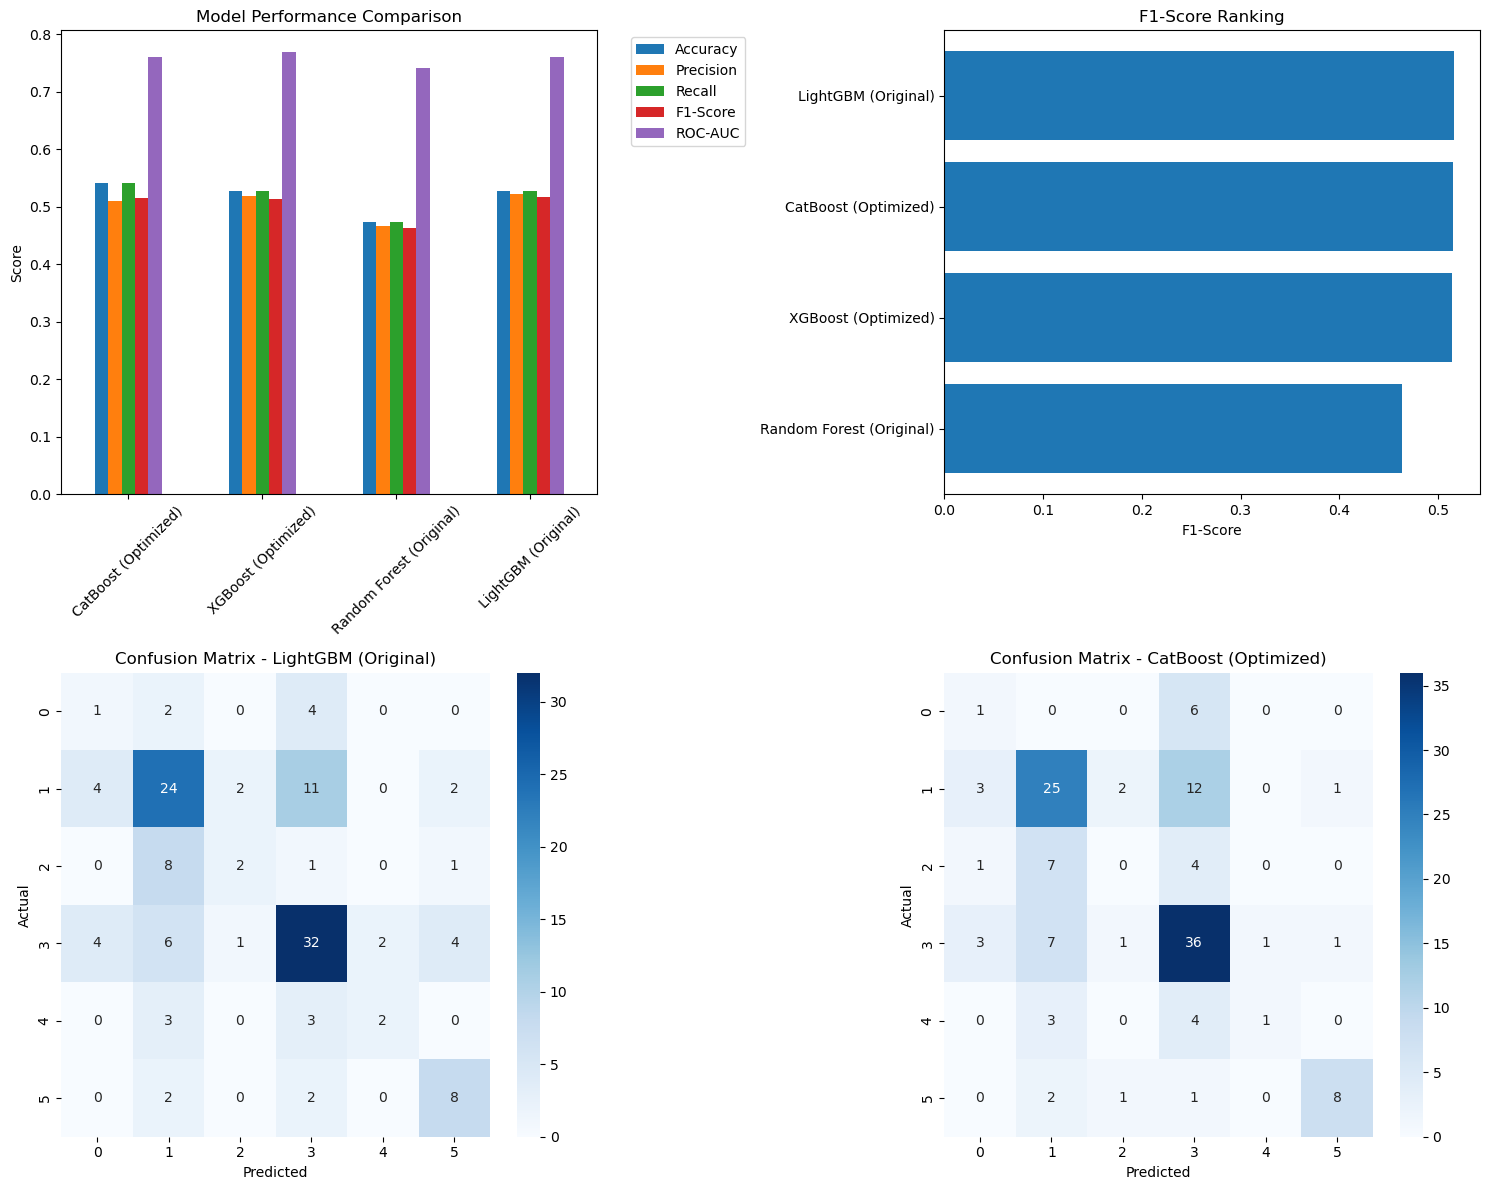


=== FINAL MODEL RANKINGS ===
                          Accuracy  Precision  Recall  F1-Score  ROC-AUC
LightGBM (Original)         0.5267     0.5229  0.5267    0.5166   0.7604
CatBoost (Optimized)        0.5420     0.5107  0.5420    0.5151   0.7604
XGBoost (Optimized)         0.5267     0.5182  0.5267    0.5140   0.7686
Random Forest (Original)    0.4733     0.4671  0.4733    0.4638   0.7417

=== TOP 2 MODELS SELECTED FOR DEPLOYMENT ===
1. LightGBM (Original): F1-Score = 0.5166
2. CatBoost (Optimized): F1-Score = 0.5151


In [29]:
# Cell 9: Model Evaluation and Comparison

def comprehensive_model_evaluation(models, X_test, y_test, label_encoder):
    """Comprehensive evaluation of all models"""
    print("Performing comprehensive model evaluation...")
    
    evaluation_results = {}
    
    for model_name, model_info in models.items():
        if isinstance(model_info, dict) and 'model' in model_info:
            model = model_info['model']
        else:
            model = model_info
        
        print(f"\nEvaluating {model_name}...")
        
        try:
            # Predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
            
            # Basic metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            # Per-class metrics
            precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
            recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
            f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)
            
            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            
            # ROC AUC
            try:
                if len(np.unique(y_test)) > 2:
                    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
                else:
                    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            except:
                roc_auc = None
            
            # Store results
            evaluation_results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'precision_per_class': precision_per_class,
                'recall_per_class': recall_per_class,
                'f1_per_class': f1_per_class,
                'confusion_matrix': cm,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            # Print classification report
            print(f"Classification Report for {model_name}:")
            print(classification_report(
                y_test, y_pred, 
                target_names=label_encoder.classes_,
                zero_division=0
            ))
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
            continue
    
    return evaluation_results

def visualize_model_comparison(evaluation_results):
    """Create comprehensive visualizations for model comparison"""
    # Metrics comparison
    metrics_df = pd.DataFrame({
        model: {
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'ROC-AUC': results['roc_auc'] if results['roc_auc'] else 0
        }
        for model, results in evaluation_results.items()
    }).T
    
    # Plot metrics comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Metrics bar plot
    metrics_df.plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # F1-Score comparison
    f1_scores = metrics_df['F1-Score'].sort_values(ascending=True)
    axes[0, 1].barh(range(len(f1_scores)), f1_scores.values)
    axes[0, 1].set_yticks(range(len(f1_scores)))
    axes[0, 1].set_yticklabels(f1_scores.index)
    axes[0, 1].set_title('F1-Score Ranking')
    axes[0, 1].set_xlabel('F1-Score')
    
    # Confusion matrices for top 2 models
    top_models = metrics_df.sort_values('F1-Score', ascending=False).head(2)
    
    for i, (model_name, _) in enumerate(top_models.iterrows()):
        cm = evaluation_results[model_name]['confusion_matrix']
        ax = axes[1, i]
        
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
        ax.set_title(f'Confusion Matrix - {model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Evaluate models
if optimized_models is not None and data_splits is not None:
    # Combine original and optimized models for comparison
    all_models_for_eval = {}
    
    # Add optimized models
    for name, info in optimized_models.items():
        all_models_for_eval[f"{name} (Optimized)"] = info['model']
    
    # Add original trained models for comparison
    if trained_models:
        for name, model in trained_models.items():
            if name not in [m.split(' (')[0] for m in all_models_for_eval.keys()]:
                all_models_for_eval[f"{name} (Original)"] = model
    
    # Perform evaluation
    final_evaluation = comprehensive_model_evaluation(
        all_models_for_eval,
        data_splits['X_test'],
        data_splits['y_test'],
        data_splits['label_encoder']
    )
    
    # Visualize results
    if final_evaluation:
        print("\n=== COMPREHENSIVE MODEL EVALUATION ===")
        metrics_comparison = visualize_model_comparison(final_evaluation)
        
        print("\n=== FINAL MODEL RANKINGS ===")
        print(metrics_comparison.sort_values('F1-Score', ascending=False).round(4))
        
        # Select top 2 models for deployment
        best_models = metrics_comparison.sort_values('F1-Score', ascending=False).head(2)
        best_model_names = best_models.index.tolist()
        
        print(f"\n=== TOP 2 MODELS SELECTED FOR DEPLOYMENT ===")
        for i, model_name in enumerate(best_model_names, 1):
            print(f"{i}. {model_name}: F1-Score = {best_models.loc[model_name, 'F1-Score']:.4f}")
        
else:
    final_evaluation = None
    best_model_names = None

Analyzing feature importance...

Top 10 features for CatBoost (Optimized):
   1. Duration: 9.3342
   2. Height: 8.5763
   3. OnsetAge: 8.4013
   4. ISInsightPresent: 6.3321
   5. Weight: 5.9139
   6. chkDrRecommend: 5.5182
   7. RespiratoryRate: 5.0888
   8. BP_Diff: 4.5054
   9. BMI: 4.4948
  10. IsSubstanceReported: 4.0977

Top 10 features for XGBoost (Optimized):
   1. IsSubstanceReported: 0.1080
   2. ISPreceptionReported: 0.0882
   3. ISContentObsessious: 0.0342
   4. ISObjectiveEuphoric: 0.0326
   5. ISContentParanoia: 0.0291
   6. IsMarijuana: 0.0252
   7. Temp: 0.0246
   8. ISPreceptionVisual: 0.0212
   9. chkDrRecommend: 0.0203
  10. ISSpeechMute: 0.0194

Top 10 features for Random Forest (Original):
   1. Height: 0.0686
   2. OnsetAge: 0.0544
   3. IsSubstanceReported: 0.0541
   4. chkDrRecommend: 0.0476
   5. Duration: 0.0446
   6. BMI: 0.0396
   7. Weight: 0.0391
   8. BP_Diff: 0.0355
   9. Mean_BP: 0.0345
  10. ISPreceptionAuditory: 0.0340

Top 10 features for LightGBM (Or

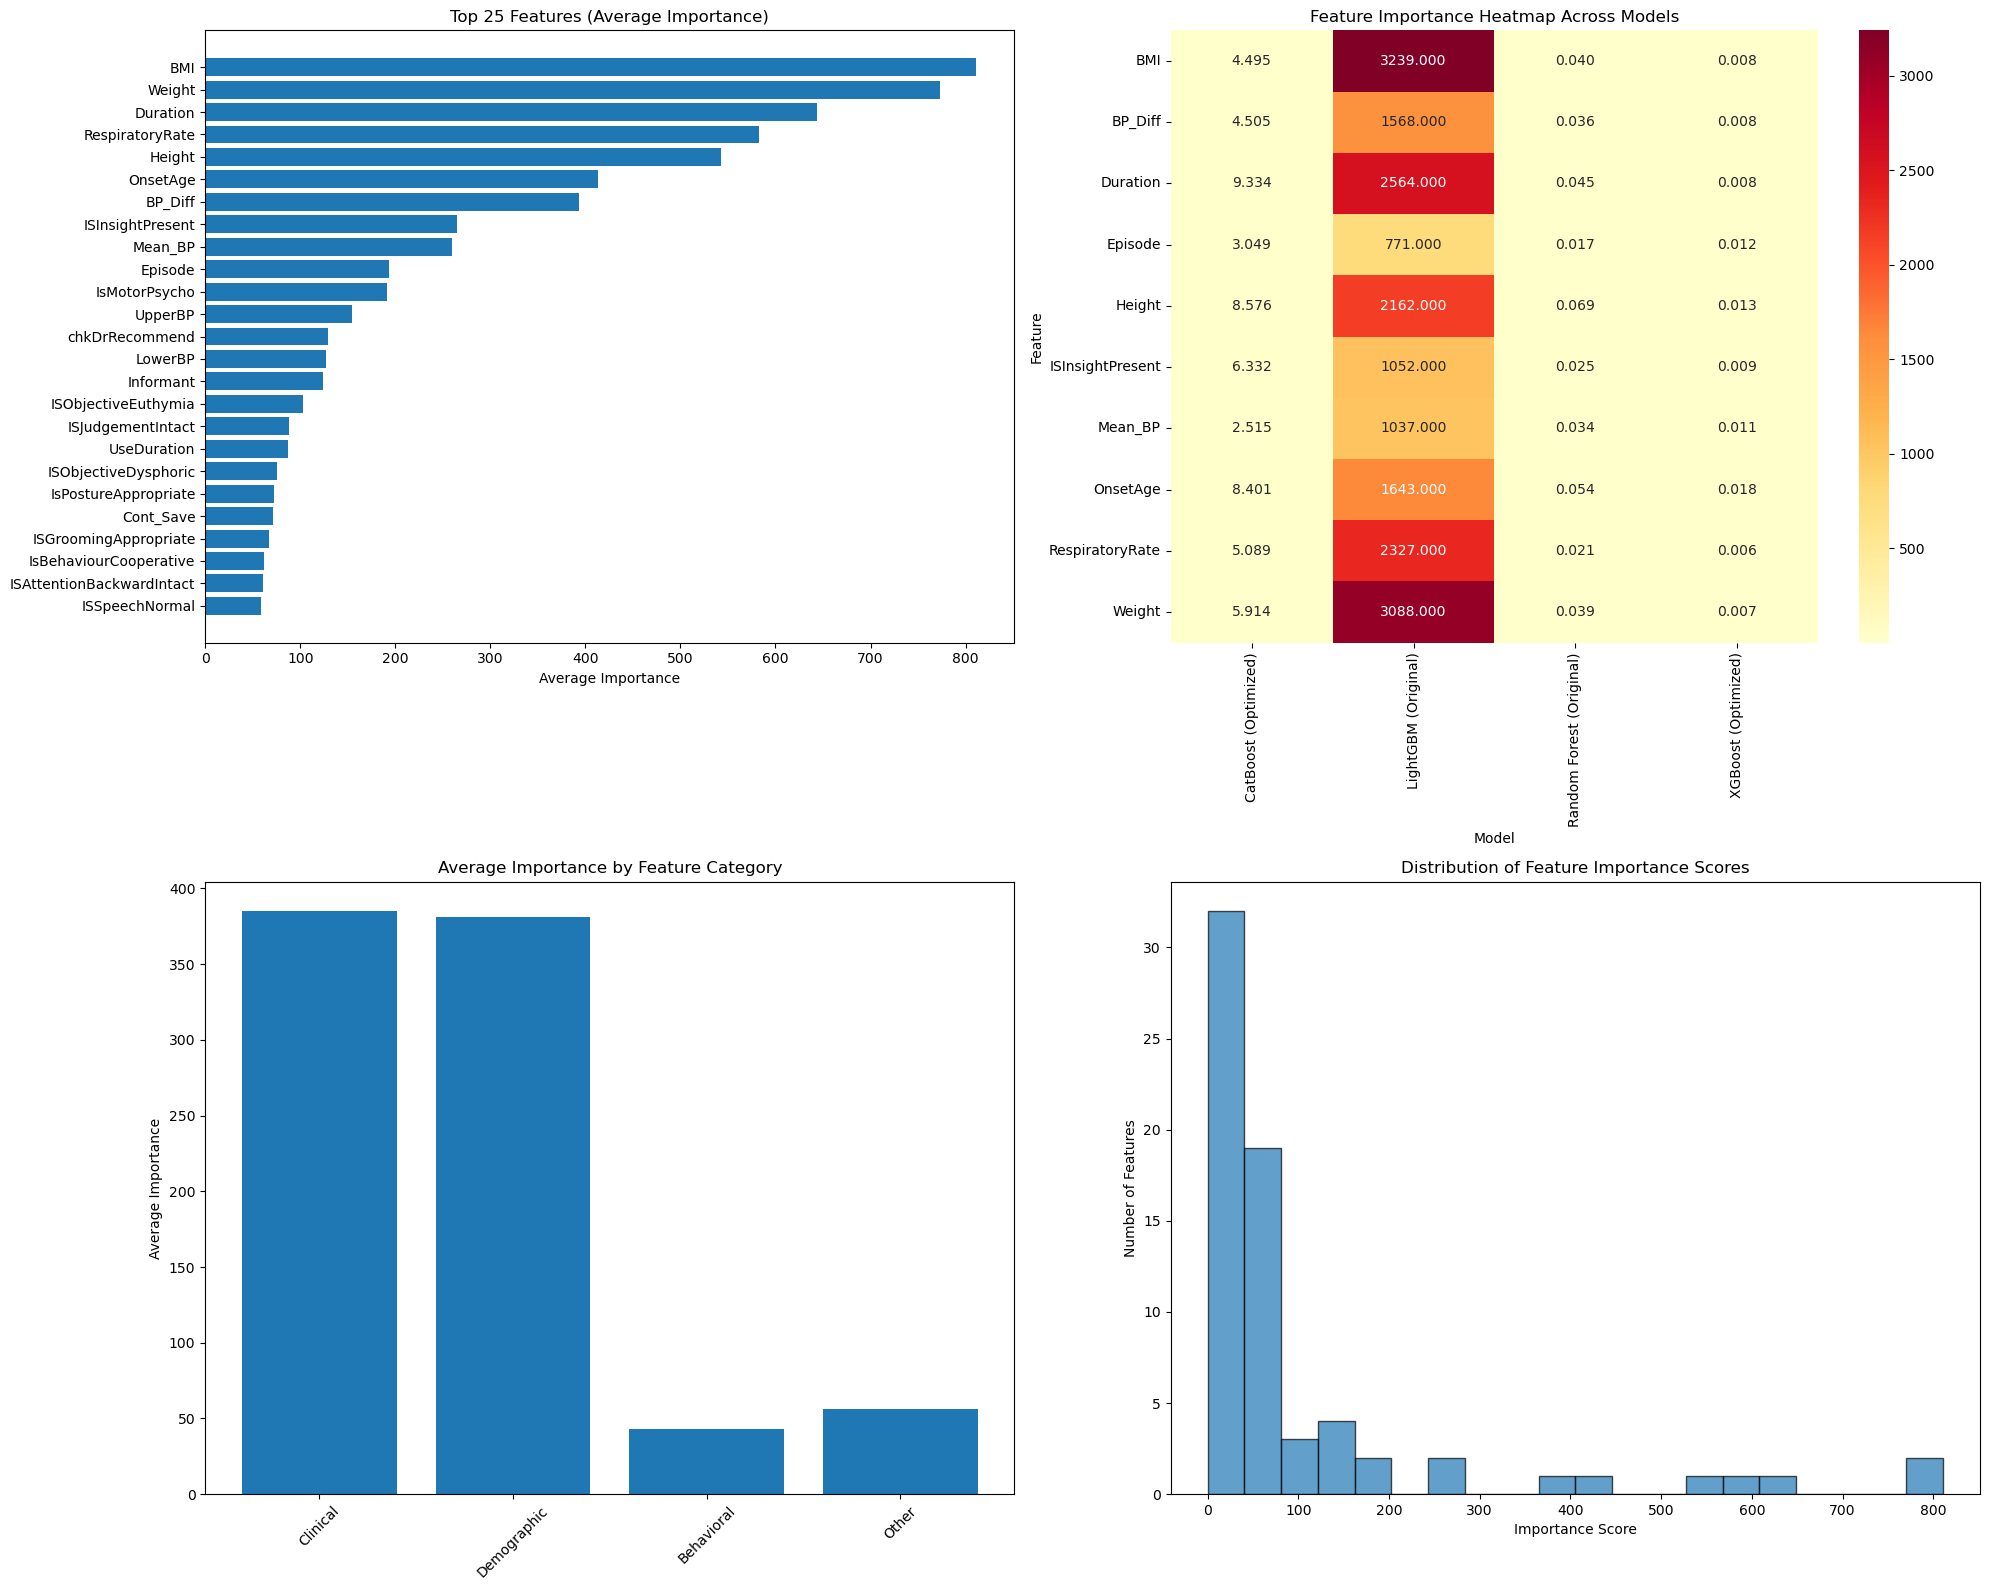


=== TOP 15 MOST IMPORTANT FEATURES ===
         feature  avg_importance
             BMI        810.8856
          Weight        773.4900
        Duration        643.3467
 RespiratoryRate        583.0288
          Height        542.6646
        OnsetAge        412.8685
         BP_Diff        393.1372
ISInsightPresent        264.5914
         Mean_BP        259.8902
         Episode        193.5193
   IsMotorPsycho        190.7321
         UpperBP        154.5202
  chkDrRecommend        128.8965
         LowerBP        126.6171
       Informant        123.9726

=== FEATURE CATEGORIES SUMMARY ===
Clinical: 8 features
Demographic: 3 features
Behavioral: 2 features
Other: 56 features


In [30]:
# Cell 10: Feature Importance Analysis

def analyze_feature_importance(models, feature_names, evaluation_results):
    """Analyze and visualize feature importance across models"""
    print("Analyzing feature importance...")
    
    importance_data = {}
    
    for model_name, model_info in models.items():
        if isinstance(model_info, dict) and 'model' in model_info:
            model = model_info['model']
        else:
            model = model_info
        
        try:
            # Extract feature importance based on model type
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):
                importances = np.abs(model.coef_).mean(axis=0)
            else:
                print(f"Cannot extract feature importance for {model_name}")
                continue
            
            # Store importance data
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            importance_data[model_name] = importance_df
            
            print(f"\nTop 10 features for {model_name}:")
            for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
                print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")
                
        except Exception as e:
            print(f"Error analyzing {model_name}: {e}")
            continue
    
    return importance_data

def visualize_feature_importance(importance_data, top_n=20):
    """Create comprehensive feature importance visualizations"""
    if not importance_data:
        print("No feature importance data available")
        return
    
    # Calculate average importance across models
    all_features = set()
    for model_importance in importance_data.values():
        all_features.update(model_importance['feature'].tolist())
    
    avg_importance = {}
    for feature in all_features:
        importances = []
        for model_importance in importance_data.values():
            feature_importance = model_importance[model_importance['feature'] == feature]
            if not feature_importance.empty:
                importances.append(feature_importance['importance'].iloc[0])
        
        if importances:
            avg_importance[feature] = np.mean(importances)
    
    # Create average importance dataframe
    avg_importance_df = pd.DataFrame([
        {'feature': feature, 'avg_importance': importance}
        for feature, importance in avg_importance.items()
    ]).sort_values('avg_importance', ascending=False)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Average importance ranking
    top_features = avg_importance_df.head(top_n)
    axes[0, 0].barh(range(len(top_features)), top_features['avg_importance'])
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['feature'])
    axes[0, 0].set_title(f'Top {top_n} Features (Average Importance)')
    axes[0, 0].set_xlabel('Average Importance')
    axes[0, 0].invert_yaxis()
    
    # Feature importance comparison across models
    if len(importance_data) > 1:
        # Select top features for comparison
        comparison_features = top_features.head(10)['feature'].tolist()
        
        comparison_data = []
        for model_name, model_importance in importance_data.items():
            for feature in comparison_features:
                feature_row = model_importance[model_importance['feature'] == feature]
                if not feature_row.empty:
                    comparison_data.append({
                        'Model': model_name,
                        'Feature': feature,
                        'Importance': feature_row['importance'].iloc[0]
                    })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Pivot for heatmap
        heatmap_data = comparison_df.pivot(index='Feature', columns='Model', values='Importance')
        
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', ax=axes[0, 1], cmap='YlOrRd')
        axes[0, 1].set_title('Feature Importance Heatmap Across Models')
    
    # Feature categories analysis
    feature_categories = {
        'NLP': [f for f in avg_importance_df['feature'] if any(term in f.lower() for term in ['sentiment', 'keyword', 'text', 'urgency'])],
        'Clinical': [f for f in avg_importance_df['feature'] if any(term in f.lower() for term in ['bp', 'temp', 'weight', 'height', 'bmi'])],
        'Demographic': [f for f in avg_importance_df['feature'] if any(term in f.lower() for term in ['age', 'onset', 'duration'])],
        'Behavioral': [f for f in avg_importance_df['feature'] if any(term in f.lower() for term in ['hygiene', 'behavior', 'substance'])],
        'Other': []
    }
    
    # Assign uncategorized features to 'Other'
    categorized_features = set()
    for features in feature_categories.values():
        categorized_features.update(features)
    
    feature_categories['Other'] = [f for f in avg_importance_df['feature'] if f not in categorized_features]
    
    # Calculate category importance
    category_importance = {}
    for category, features in feature_categories.items():
        if features:
            category_scores = [avg_importance[f] for f in features if f in avg_importance]
            category_importance[category] = np.mean(category_scores) if category_scores else 0
    
    # Plot category importance
    categories = list(category_importance.keys())
    importances = list(category_importance.values())
    
    axes[1, 0].bar(categories, importances)
    axes[1, 0].set_title('Average Importance by Feature Category')
    axes[1, 0].set_ylabel('Average Importance')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Feature importance distribution
    all_importances = list(avg_importance.values())
    axes[1, 1].hist(all_importances, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Distribution of Feature Importance Scores')
    axes[1, 1].set_xlabel('Importance Score')
    axes[1, 1].set_ylabel('Number of Features')
    
    plt.tight_layout()
    plt.show()
    
    return avg_importance_df, feature_categories

# Analyze feature importance
if all_models_for_eval is not None and data_splits is not None:
    feature_importance_analysis = analyze_feature_importance(
        all_models_for_eval,
        data_splits['feature_names'],
        final_evaluation
    )
    
    # Visualize feature importance
    if feature_importance_analysis:
        print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
        avg_importance_df, feature_categories = visualize_feature_importance(
            feature_importance_analysis, top_n=25
        )
        
        print("\n=== TOP 15 MOST IMPORTANT FEATURES ===")
        print(avg_importance_df.head(15).to_string(index=False, float_format='%.4f'))
        
        print("\n=== FEATURE CATEGORIES SUMMARY ===")
        for category, features in feature_categories.items():
            if features:
                print(f"{category}: {len(features)} features")
        
else:
    feature_importance_analysis = None
    avg_importance_df = None

In [31]:
# Cell 11: Model Saving and Persistence

def save_ml_pipeline(models, data_components, feature_info, model_evaluation, save_dir='models'):
    """Save complete ML pipeline components"""
    print(f"Saving ML pipeline to {save_dir}/...")
    
    # Create models directory
    os.makedirs(save_dir, exist_ok=True)
    
    saved_files = []
    
    try:
        # Save trained models
        for model_name, model_info in models.items():
            if isinstance(model_info, dict) and 'model' in model_info:
                model = model_info['model']
                best_params = model_info.get('best_params', {})
            else:
                model = model_info
                best_params = {}
            
            # Clean model name for filename
            clean_name = model_name.replace(' ', '_').replace('(', '').replace(')', '')
            model_path = os.path.join(save_dir, f"{clean_name}_model.pkl")
            
            joblib.dump(model, model_path)
            saved_files.append(model_path)
            print(f"  Saved model: {model_path}")
            
            # Save model parameters
            if best_params:
                params_path = os.path.join(save_dir, f"{clean_name}_params.pkl")
                joblib.dump(best_params, params_path)
                saved_files.append(params_path)
        
        # Save data preprocessing components
        if data_components:
            # Save scaler
            if 'scaler' in data_components:
                scaler_path = os.path.join(save_dir, "scaler.pkl")
                joblib.dump(data_components['scaler'], scaler_path)
                saved_files.append(scaler_path)
                print(f"  Saved scaler: {scaler_path}")
            
            # Save label encoder
            if 'label_encoder' in data_components:
                le_path = os.path.join(save_dir, "label_encoder.pkl")
                joblib.dump(data_components['label_encoder'], le_path)
                saved_files.append(le_path)
                print(f"  Saved label encoder: {le_path}")
        
        # Save feature information
        if feature_info:
            feature_info_path = os.path.join(save_dir, "feature_info.pkl")
            joblib.dump(feature_info, feature_info_path)
            saved_files.append(feature_info_path)
            print(f"  Saved feature info: {feature_info_path}")
        
        # Save model evaluation results
        if model_evaluation:
            # Convert numpy arrays to lists for JSON serialization
            serializable_evaluation = {}
            for model_name, results in model_evaluation.items():
                serializable_results = {}
                for key, value in results.items():
                    if isinstance(value, np.ndarray):
                        serializable_results[key] = value.tolist()
                    elif key in ['predictions', 'probabilities']:  # Skip large arrays
                        continue
                    else:
                        serializable_results[key] = value
                serializable_evaluation[model_name] = serializable_results
            
            evaluation_path = os.path.join(save_dir, "model_evaluation.pkl")
            joblib.dump(serializable_evaluation, evaluation_path)
            saved_files.append(evaluation_path)
            print(f"  Saved evaluation results: {evaluation_path}")
        
        # Create model metadata
        metadata = {
            'timestamp': datetime.now().isoformat(),
            'models_saved': list(models.keys()),
            'feature_count': len(feature_info.get('feature_names', [])) if feature_info else 0,
            'target_classes': len(data_components.get('label_encoder', {}).classes_) if data_components and 'label_encoder' in data_components else 0,
            'pipeline_version': '1.0',
            'saved_files': saved_files
        }
        
        metadata_path = os.path.join(save_dir, "pipeline_metadata.pkl")
        joblib.dump(metadata, metadata_path)
        saved_files.append(metadata_path)
        print(f"  Saved metadata: {metadata_path}")
        
        print(f"\nSuccessfully saved {len(saved_files)} files to {save_dir}/")
        return True, saved_files
        
    except Exception as e:
        print(f"Error saving pipeline: {e}")
        return False, []

def create_model_summary(models, evaluation_results, feature_importance_data):
    """Create comprehensive model summary"""
    summary = {
        'pipeline_info': {
            'creation_date': datetime.now().isoformat(),
            'total_models': len(models),
            'evaluation_completed': evaluation_results is not None,
            'feature_analysis_completed': feature_importance_data is not None
        },
        'model_performance': {},
        'best_models': [],
        'feature_insights': {}
    }
    
    if evaluation_results:
        # Extract performance metrics
        for model_name, results in evaluation_results.items():
            summary['model_performance'][model_name] = {
                'accuracy': results.get('accuracy', 0),
                'precision': results.get('precision', 0),
                'recall': results.get('recall', 0),
                'f1_score': results.get('f1_score', 0),
                'roc_auc': results.get('roc_auc', 0)
            }
        
        # Identify best models
        performance_df = pd.DataFrame(summary['model_performance']).T
        best_models = performance_df.sort_values('f1_score', ascending=False).head(2)
        summary['best_models'] = best_models.index.tolist()
    
    if feature_importance_data:
        # Get top features from first model
        first_model_features = list(feature_importance_data.values())[0]
        summary['feature_insights']['top_features'] = first_model_features.head(10).to_dict('records')
    
    return summary

# Save the complete ML pipeline
if all_models_for_eval is not None and data_splits is not None:
    # Prepare feature information
    feature_info = {
        'feature_names': data_splits['feature_names'],
        'selected_features': selected_feature_names if 'selected_feature_names' in locals() else None,
        'feature_importance': avg_importance_df.to_dict('records') if 'avg_importance_df' in locals() and avg_importance_df is not None else None
    }
    
    # Save pipeline
    success, saved_files = save_ml_pipeline(
        all_models_for_eval,
        data_splits,
        feature_info,
        final_evaluation
    )
    
    if success:
        print("\n=== PIPELINE SAVING SUMMARY ===")
        print(f"Models saved: {len(all_models_for_eval)}")
        print(f"Total files created: {len(saved_files)}")
        
        # Create and save model summary
        model_summary = create_model_summary(
            all_models_for_eval,
            final_evaluation,
            feature_importance_analysis if 'feature_importance_analysis' in locals() else None
        )
        
        summary_path = "models/model_summary.pkl"
        joblib.dump(model_summary, summary_path)
        print(f"Model summary saved: {summary_path}")
        
        print("\n=== RECOMMENDED MODELS FOR DEPLOYMENT ===")
        if 'best_models' in model_summary and model_summary['best_models']:
            for i, model_name in enumerate(model_summary['best_models'], 1):
                performance = model_summary['model_performance'][model_name]
                print(f"{i}. {model_name}:")
                print(f"   F1-Score: {performance['f1_score']:.4f}")
                print(f"   Accuracy: {performance['accuracy']:.4f}")
                print(f"   Precision: {performance['precision']:.4f}")
                print(f"   Recall: {performance['recall']:.4f}")
    
else:
    print("No models available for saving.")

Saving ML pipeline to models/...
  Saved model: models\CatBoost_Optimized_model.pkl
  Saved model: models\XGBoost_Optimized_model.pkl
  Saved model: models\Random_Forest_Original_model.pkl
  Saved model: models\LightGBM_Original_model.pkl
  Saved scaler: models\scaler.pkl
  Saved label encoder: models\label_encoder.pkl
  Saved feature info: models\feature_info.pkl
  Saved evaluation results: models\model_evaluation.pkl
  Saved metadata: models\pipeline_metadata.pkl

Successfully saved 9 files to models/

=== PIPELINE SAVING SUMMARY ===
Models saved: 4
Total files created: 9
Model summary saved: models/model_summary.pkl

=== RECOMMENDED MODELS FOR DEPLOYMENT ===
1. LightGBM (Original):
   F1-Score: 0.5166
   Accuracy: 0.5267
   Precision: 0.5229
   Recall: 0.5267
2. CatBoost (Optimized):
   F1-Score: 0.5151
   Accuracy: 0.5420
   Precision: 0.5107
   Recall: 0.5420


In [34]:
# Cell 12: Model Validation and Testing

def load_and_validate_saved_models(models_dir='models'):
    """Load saved models and validate their functionality"""
    print(f"Loading and validating models from {models_dir}/...")
    
    loaded_components = {}
    
    try:
        # Load metadata first
        metadata_path = os.path.join(models_dir, "pipeline_metadata.pkl")
        if os.path.exists(metadata_path):
            metadata = joblib.load(metadata_path)
            loaded_components['metadata'] = metadata
            print(f"Pipeline created: {metadata.get('timestamp', 'Unknown')}")
            print(f"Models available: {len(metadata.get('models_saved', []))}")
        
        # Load preprocessing components
        scaler_path = os.path.join(models_dir, "scaler.pkl")
        if os.path.exists(scaler_path):
            loaded_components['scaler'] = joblib.load(scaler_path)
            print("✓ Scaler loaded successfully")
        
        le_path = os.path.join(models_dir, "label_encoder.pkl")
        if os.path.exists(le_path):
            loaded_components['label_encoder'] = joblib.load(le_path)
            print("✓ Label encoder loaded successfully")
        
        # Load feature information
        feature_info_path = os.path.join(models_dir, "feature_info.pkl")
        if os.path.exists(feature_info_path):
            loaded_components['feature_info'] = joblib.load(feature_info_path)
            print("✓ Feature information loaded successfully")
        
        # Load models
        loaded_components['models'] = {}
        for filename in os.listdir(models_dir):
            if filename.endswith('_model.pkl'):
                model_name = filename.replace('_model.pkl', '').replace('_', ' ')
                model_path = os.path.join(models_dir, filename)
                try:
                    model = joblib.load(model_path)
                    loaded_components['models'][model_name] = model
                    print(f"✓ Model '{model_name}' loaded successfully")
                except Exception as e:
                    print(f"✗ Failed to load model '{model_name}': {e}")
        
        print(f"\nTotal models loaded: {len(loaded_components['models'])}")
        return loaded_components
        
    except Exception as e:
        print(f"Error loading models: {e}")
        return None

def test_model_predictions(loaded_components, test_data=None):
    """Test loaded models with sample predictions"""
    if not loaded_components or 'models' not in loaded_components:
        print("No models available for testing")
        return
    
    print("\nTesting model predictions...")
    
    # Use test data if available, otherwise create sample data
    if test_data is not None and 'X_test' in test_data:
        X_test_sample = test_data['X_test'][:5]  # Use first 5 test samples
        y_test_sample = test_data['y_test'][:5] if 'y_test' in test_data else None
        print("Using actual test data for validation")
    else:
        # Create sample data based on feature info
        feature_info = loaded_components.get('feature_info', {})
        feature_names = feature_info.get('feature_names', [])
        
        if feature_names:
            n_features = len(feature_names)
            X_test_sample = np.random.randn(3, n_features)  # 3 sample predictions
            y_test_sample = None
            print(f"Using synthetic test data with {n_features} features")
        else:
            print("No feature information available for testing")
            return
    
    # Test each model
    prediction_results = {}
    
    for model_name, model in loaded_components['models'].items():
        try:
            # Make predictions
            predictions = model.predict(X_test_sample)
            probabilities = model.predict_proba(X_test_sample)
            
            # Convert predictions back to original labels if label encoder available
            if 'label_encoder' in loaded_components:
                le = loaded_components['label_encoder']
                predicted_labels = le.inverse_transform(predictions)
            else:
                predicted_labels = predictions
            
            prediction_results[model_name] = {
                'predictions': predicted_labels,
                'probabilities': probabilities,
                'success': True
            }
            
            print(f"\n✓ {model_name} predictions successful:")
            for i, (pred, prob) in enumerate(zip(predicted_labels, probabilities)):
                max_prob = np.max(prob)
                print(f"  Sample {i+1}: {pred} (confidence: {max_prob:.3f})")
                
        except Exception as e:
            print(f"\n✗ {model_name} prediction failed: {e}")
            prediction_results[model_name] = {
                'success': False,
                'error': str(e)
            }
    
    return prediction_results

def generate_final_report(loaded_components, prediction_results):
    """Generate final validation report"""
    print("\n" + "="*60)
    print("           FINAL MODEL VALIDATION REPORT")
    print("="*60)
    
    # Pipeline status
    if loaded_components:
        metadata = loaded_components.get('metadata', {})
        print(f"\n📊 PIPELINE STATUS:")
        print(f"   Created: {metadata.get('timestamp', 'Unknown')}")
        print(f"   Version: {metadata.get('pipeline_version', 'Unknown')}")
        print(f"   Models: {len(loaded_components.get('models', {}))}")
        print(f"   Features: {metadata.get('feature_count', 'Unknown')}")
        print(f"   Classes: {metadata.get('target_classes', 'Unknown')}")
    
    # Model validation status
    print(f"\n🤖 MODEL VALIDATION:")
    if prediction_results:
        successful_models = sum(1 for result in prediction_results.values() if result.get('success', False))
        total_models = len(prediction_results)
        print(f"   Successful: {successful_models}/{total_models}")
        
        for model_name, result in prediction_results.items():
            status = "✓ PASS" if result.get('success', False) else "✗ FAIL"
            print(f"   {model_name}: {status}")
    else:
        print("   No prediction tests performed")
    
    # Component status
    print(f"\n🔧 COMPONENT STATUS:")
    components = ['scaler', 'label_encoder', 'feature_info', 'models']
    for component in components:
        status = "✓ Loaded" if component in loaded_components else "✗ Missing"
        print(f"   {component.replace('_', ' ').title()}: {status}")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    if loaded_components and 'models' in loaded_components:
        if len(loaded_components['models']) >= 2:
            print("   ✓ Multiple models available for ensemble predictions")
        else:
            print("   ⚠ Consider training additional models for better performance")
        
        if 'scaler' in loaded_components and 'label_encoder' in loaded_components:
            print("   ✓ Pipeline ready for production deployment")
        else:
            print("   ⚠ Missing preprocessing components - check pipeline")
    else:
        print("   ✗ No models available - pipeline needs to be retrained")
    
    print("\n" + "="*60)
    print("                    VALIDATION COMPLETE")
    print("="*60)

# Perform final validation
print("\n=== FINAL MODEL VALIDATION ===")

# Load saved models
loaded_pipeline = load_and_validate_saved_models()

# Test predictions
if loaded_pipeline:
    test_results = test_model_predictions(
        loaded_pipeline,
        test_data=data_splits if 'data_splits' in locals() and data_splits is not None else None
    )
    
    # Generate final report
    generate_final_report(loaded_pipeline, test_results)
    
    # Save validation results
    if test_results:
        validation_summary = {
            'validation_timestamp': datetime.now().isoformat(),
            'models_tested': len(test_results),
            'successful_models': sum(1 for r in test_results.values() if r.get('success', False)),
            'pipeline_ready': all(comp in loaded_pipeline for comp in ['models', 'scaler', 'label_encoder']),
            'test_results': {name: {'success': r.get('success', False)} for name, r in test_results.items()}
        }
        
        validation_path = "models/validation_report.pkl"
        joblib.dump(validation_summary, validation_path)
        print(f"\nValidation report saved: {validation_path}")

else:
    print("❌ Failed to load saved models. Please check the models directory.")

print("\n🎉 ML Pipeline notebook execution completed!")


=== FINAL MODEL VALIDATION ===
Loading and validating models from models/...
Pipeline created: 2025-07-01T18:26:35.369183
Models available: 4
✓ Scaler loaded successfully
✓ Label encoder loaded successfully
✓ Feature information loaded successfully
✓ Model 'CatBoost Optimized' loaded successfully
✓ Model 'LightGBM Original' loaded successfully
✓ Model 'Random Forest Original' loaded successfully
✓ Model 'XGBoost Optimized' loaded successfully

Total models loaded: 4

Testing model predictions...
Using actual test data for validation

✓ CatBoost Optimized predictions successful:
  Sample 1: psychosis (confidence: 0.700)
  Sample 2: psychosis (confidence: 0.725)
  Sample 3: mood_disorder (confidence: 0.752)
  Sample 4: psychosis (confidence: 0.975)
  Sample 5: mood_disorder (confidence: 0.753)

✓ LightGBM Original predictions successful:
  Sample 1: psychosis (confidence: 0.852)
  Sample 2: psychosis (confidence: 0.995)
  Sample 3: mood_disorder (confidence: 0.864)
  Sample 4: psychosis